In [1]:
import sys
sys.path.append('/data/test/zhouying/完整交付代码')

In [2]:
import torch
import numpy as np
from utils.plots import ExperimentLogger
from method.clustered.clustered import clustered_fl
from method.my.my import my_fl
from method.fedavg.fedavg import fed_avg_fl
from method.ditto.ditto import ditto_fl
from method.local.local import local_fl
from init_devices import init_clients_and_server
from init_datasets import load_dataset
import argparse
from utils.plots import draw_result_table
torch.cuda.set_device(1)


In [3]:
def parse_args():
    """parse the command line args

    Returns:
        args: a namespace object including args
    """
    parser = argparse.ArgumentParser(description=__doc__)
    parser.add_argument(
        '--dataset',
        help="name of dataset;"
        " possible are `EMNIST`, `FashionMNIST`, `CIFAR10`，`CIFAR100`, `Shakespeare`",
        type=str,
        default='CIFAR10'
    )
    parser.add_argument(
        '--method',
        help = "the method to be used;"
               " possible are `My`,`Clustered`, `FedAvg`, `Ditto`, `Local`, 'Overlap'",
        type=str,
        default='My'
    )
    parser.add_argument(
        '--pathological_split',
        help='if selected, the dataset will be split as in'
             '"Communication-Efficient Learning of Deep Networks from Decentralized Data";'
             'i.e., each client will receive `n_shards` of dataset, where each shard contains at most two classes',
        action='store_true'
    )
    parser.add_argument(
        '--n_shards',
        help='number of shards given to each clients/task; ignored if `--pathological_split` is not used;'
             'default is 2',
        type=int,
        default=2
    )
    parser.add_argument(
        '--n_clients',
        help = "the number of clients",
        type=int,
        default=10
    )
    parser.add_argument(
        '--n_clusters',
        help = "initialize the number of cluster of data distribution",
        type=int,
        default=3
    )
    parser.add_argument(
        '--alpha',
        help = "the parameter of dirichlet",
        type=float,
        default=1.0
    )
    parser.add_argument(
        '--local_epochs',
        help='number of local epochs before communication; default is 1',
        type=int,
        default=1
    )
    parser.add_argument(
        "--n_rounds",
        help="number of communication rounds",
        type=int,
        default=100
    )
    parser.add_argument(
        "--n_sample",
        help="number of sample to use",
        type=int,
        default=20000
    )
    parser.add_argument(
        "--train_frac",
        help="fraction of train samples",
        type=float,
        default=0.8
    )
    parser.add_argument(
        "--val_frac",
        help="fraction of validation samples in train samples",
        type=float,
        default=0
    )   
    parser.add_argument(
        "--seed",
        help='random seed',
        type=int,
        default=42
    )
    args = parser.parse_args()
    return args

In [ ]:
# 手动创建 Namespace 对象并设置属性
args = argparse.Namespace(
    dataset='CIFAR10',
    method='PFCAL',
    pathological_split=False,
    n_shards=2,
    n_clients=20,
    n_clusters=3,
    alpha=1.0,
    local_epochs=1,
    n_rounds=100,
    n_sample=40000,
    train_frac=0.8,
    val_frac=0.0,
    seed=42
)

# 将 Namespace 对象转换为字典
args_dict = vars(args)
print(args_dict)

In [5]:
from copy import deepcopy
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

def Com_clinet(clients,similarities):
    a=deepcopy(clients)
    similarity_matrix = np.array(similarities)  # 确保相似性矩阵已经正确定义和初始化
    # 尝试不同的聚类数目
    best_num_clusters = 2  # 假设2为起始聚类数目
    best_silhouette = -np.inf

    for n_clusters in range(2, 10):  # 尝试从2到9个聚类
        kmeans = KMeans(n_clusters=n_clusters, random_state=0)
        kmeans.fit(similarity_matrix)
        
        # 计算轮廓系数
        silhouette_avg = silhouette_score(similarity_matrix, kmeans.labels_)
        
        # 记录最优的聚类数目
        if silhouette_avg > best_silhouette:
            best_silhouette = silhouette_avg
            best_num_clusters = n_clusters
            best_labels = kmeans.labels_  # 保存当前最优的聚类标签
        
        # print(f"最优的聚类数目是: {best_num_clusters}")
        
        data_points = list(range(len(similarity_matrix)))
        clustered_data_points = {}
        for user, label in zip(data_points, best_labels):
            clustered_data_points.setdefault(label, []).append(user)
        res_idc=[]
        for cluster_id, users in clustered_data_points.items():
            res_idc.append(users)
        print(res_idc)
        return res_idc
        

In [6]:
def flatten(source):
    return torch.cat([value.flatten() for value in source.values()])
def pairwise_angles(sources):
    angles = torch.zeros([len(sources), len(sources)])
    for i, source1 in enumerate(sources):
        for j, source2 in enumerate(sources):
            s1 = flatten(source1)
            s2 = flatten(source2)
            angles[i,j] = torch.sum(s1*s2)/(torch.norm(s1)*torch.norm(s2)+1e-12)
    return angles.numpy()

def compute_pairwise_similarities(clients):
    return pairwise_angles([client.dW for client in clients])

In [7]:
from utils.plots import display_train_stats
from tqdm import tqdm


def PFCAL(args, clients, server, cfl_stats):

    EPS_1 = 0.4
    EPS_2 = 1.6   

    cluster_indices = [[client_id for client_id in range(len(clients))]]
        
    # similarities = server.compute_pairwise_similarities(clients)
    #print(similarities)
    # 进行n_rounds轮迭代
    acc_clients = []
    pbar = tqdm(total=args.n_rounds)
    client_clusters=[]
    
    for c_round in range(1, args.n_rounds+1):
        # print(cluster_indices)
    # c_round为当前的通信轮数
        # 初始时需要保证客户端和服务器模型同步
        if c_round == 1:
            for client in clients:
                client.synchronize_with_server(server)
                
        participating_clients = server.select_clients(clients, frac=0.5)

        for client in participating_clients:
            train_stats = client.compute_weight_update(epochs=args.local_epochs)
            client.reset()
        max_norm = server.compute_max_update_norm(clients)
        # 计算某个簇内的client的平均参数范数
        mean_norm = server.compute_mean_update_norm(clients)
        similarities = compute_pairwise_similarities(clients)
        if c_round == 20:
            res_idc=Com_clinet(clients,similarities)
            client_clusters = [[clients[i] for i in idcs] for idcs in res_idc]
            print(client_clusters)
            
        if client_clusters==[]:
            print("clients",clients)
            server.aggregate_weight_updates(clients)
        else:
            for idx in range(len(client_clusters)):
                server.aggregate_weight_updates(client_clusters[idx])
    
        for client in clients:
            client.synchronize_with_server(server)    
        

        acc_clients = [client.evaluate() for client in clients]
        cfl_stats.log({"acc_clients" : acc_clients, "mean_norm" : mean_norm, "max_norm" : max_norm,"rounds" : c_round, "clusters" : cluster_indices})
        pbar.update(1)
        display_train_stats(cfl_stats, EPS_1, EPS_2, args.n_rounds)
    for idc in cluster_indices:    
        server.cache_model(idc, clients[idc[0]].W, acc_clients)

In [8]:
def run_experiment(args, clients, server):

                
    cfl_stats = ExperimentLogger()

    if args.method == "Clustered":
        clustered_fl(args, clients, server, cfl_stats)
    elif args.method == "My":
        my_fl(args, clients, server, cfl_stats)    
    elif args.method == "FedAvg":
        fed_avg_fl(args, clients, server, cfl_stats)
    elif args.method == "Ditto":
        ditto_fl(args, clients, server, cfl_stats)
    elif args.method == "Local":
        local_fl(args, clients, server, cfl_stats)
    elif args.method == "PFCAL":
        PFCAL(args, clients, server, cfl_stats)
    else:
        raise IOError("possible are `My`,`Clustered`, `FedAvg`, `Ditto`, `Local`, `Overlap`")
    # elif args.method == "Overlap":
    #     overlap_fl(args, clients, server, cfl_stats)

    draw_result_table(args, clients, server)

    

In [ ]:

torch.manual_seed(args.seed)
np.random.seed(args.seed)


dataset, client_train_idcs, client_test_idcs, client_val_idcs, data_info = load_dataset(args)
print(dataset)
print(client_train_idcs)
print(len(client_train_idcs))
print(len(client_test_idcs))
print(data_info)
#     # print(dataset[0])
#     # print(client_train_idcs)
#     # print(client_test_idcs)
clients, server = init_clients_and_server(args, dataset, client_train_idcs, client_test_idcs, client_val_idcs, data_info)

#     #Now everything is set up to run our Clustered Federated Learning algorithm. During training, we will track the mean and std client accuracies, as well as the average and maximum client update norms.

torch.backends.cudnn.enabled = False
run_experiment(args, clients, server)




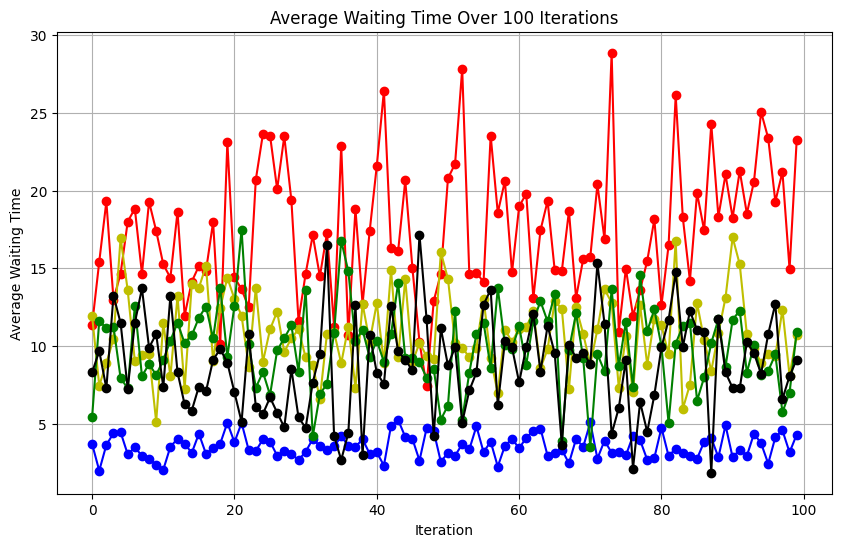

In [55]:
import numpy as np
import random
import matplotlib.pyplot as plt

# 定义设备数量和随机浮动范围
num_devices = 20
time_range = (10, 20)  # 设备训练时间的浮动范围，例如每个设备的训练时间在10-20之间
rounds_range = range(1, 6)  # r值范围为1-5

# 生成每个设备的基础训练时间，添加随机浮动
device_times = np.random.uniform(time_range[0], time_range[1], num_devices)

# 每次选择35%的设备进行训练
selection_percentage = 0.35
num_selected_devices = int(num_devices * selection_percentage)

# 定义计算平均等待时间的函数
def compute_avg_waiting_time(r, selected_devices):
    completion_times = device_times[selected_devices] * r + np.random.uniform(5)
    last_device_time = np.max(completion_times)
    waiting_times = last_device_time - completion_times
    avg_waiting_time = np.mean(waiting_times)
    return avg_waiting_time

# 主函数：找到最优的r值使平均等待时间最短
def find_best_r(selected_devices):
    best_r = None
    min_avg_waiting_time = float('inf')
    
    # 遍历每个可能的r值
    for r in rounds_range:
        avg_waiting_time = compute_avg_waiting_time(r, selected_devices)
        
        # 找到最小的平均等待时间
        if avg_waiting_time < min_avg_waiting_time:
            min_avg_waiting_time = avg_waiting_time
            best_r = r
    
    return best_r, min_avg_waiting_time


# 主函数：找到最优的r值使平均等待时间最短
def find_r(selected_devices):
    best_r = None
    
    # 遍历每个可能的r值
    avg_waiting_time_all=[]
    for r in rounds_range:
        avg_waiting_time = compute_avg_waiting_time(r, selected_devices)
        avg_waiting_time_all.append(avg_waiting_time)
    
    
    return best_r, max(avg_waiting_time_all)

# 运行100轮并记录每轮的最优等待时间
num_iterations = 100
waiting_times_over_iterations = []

for i in range(num_iterations):
    # 每次抽取随机的35%设备
    selected_devices = random.sample(range(num_devices), num_selected_devices)
    _, min_avg_waiting_time = find_best_r(selected_devices)
    waiting_times_over_iterations.append(min_avg_waiting_time)

# 绘制平均等待时间的变化曲线
plt.figure(figsize=(10, 6))
plt.plot(waiting_times_over_iterations, marker='o', linestyle='-', color='b')
plt.title('Average Waiting Time Over 100 Iterations')
plt.xlabel('Iteration')
plt.ylabel('Average Waiting Time')
plt.grid(True)
# plt.show()



waiting_times_over_iterations1=[]
for i in range(num_iterations):
    # 每次抽取随机的35%设备
    selected_devices = random.sample(range(num_devices), num_selected_devices)
    _, min_avg_waiting_time = find_r(selected_devices)
    waiting_times_over_iterations1.append(min_avg_waiting_time)

plt.plot(waiting_times_over_iterations1, marker='o', linestyle='-', color='r')

# 将20个设备随机划分为两组
group_1 = random.sample(range(num_devices), num_devices // 2)
group_2 = [i for i in range(num_devices) if i not in group_1]

# 定义计算平均等待时间的函数，增加r参数
def compute_avg_waiting_time(selected_devices, r):
    completion_times = device_times[selected_devices] * r + np.random.uniform(5)
    last_device_time = np.max(completion_times)
    waiting_times = last_device_time - completion_times
    avg_waiting_time = np.mean(waiting_times)
    return avg_waiting_time

# 运行100轮并记录每轮的平均等待时间
def run_iterations(plt,num_iterations):
    r=3
    waiting_times_over_iterations = []
    
    for i in range(num_iterations):
        # 从每组中至少选一个设备，其余的按比例从两组中随机选择
        selected_group_1 = random.sample(group_1, max(1, int(num_selected_devices * len(group_1) / num_devices)))
        selected_group_2 = random.sample(group_2, max(1, num_selected_devices - len(selected_group_1)))
        
        # 合并两组的选中设备
        selected_devices = selected_group_1 + selected_group_2

        # 计算每轮的平均等待时间
        avg_waiting_time = compute_avg_waiting_time(selected_devices, r)
        waiting_times_over_iterations.append(avg_waiting_time)
    
    plt.plot(waiting_times_over_iterations, marker='o', linestyle='-', color='y')


num_iterations = 100  # 设置总轮数
run_iterations(plt,num_iterations)

# 将设备随机划分为任意数量的组
def divide_into_groups(num_devices, num_groups):
    all_devices = list(range(num_devices))
    random.shuffle(all_devices)
    return [all_devices[i::num_groups] for i in range(num_groups)]

# 定义计算平均等待时间的函数，增加r参数
def compute_avg_waiting_time(selected_devices, r):
    completion_times = device_times[selected_devices] * r + np.random.uniform(5)
    last_device_time = np.max(completion_times)
    waiting_times = last_device_time - completion_times
    avg_waiting_time = np.mean(waiting_times)
    return avg_waiting_time

# 运行100轮并记录每轮的平均等待时间
def run_iterations(plt, num_iterations, num_groups):
    r = 3  # 随机选择r值
    waiting_times_over_iterations = []

    # 分组
    groups = divide_into_groups(num_devices, num_groups)

    for i in range(num_iterations):
        selected_devices = []

        # 从每组中至少选一个设备，其余的按比例从所有组中随机选择
        for group in groups:
            selected_from_group = random.sample(group, max(1, int(num_selected_devices * len(group) / num_devices)))
            selected_devices.extend(selected_from_group)

        # 计算每轮的平均等待时间
        avg_waiting_time = compute_avg_waiting_time(selected_devices, r)
        waiting_times_over_iterations.append(avg_waiting_time)

    # 绘制平均等待时间的变化曲线
    plt.plot(waiting_times_over_iterations, marker='o', linestyle='-', color='g')

# 运行
num_iterations = 100  # 设置总轮数
num_groups = 3  # 你可以设置你想要的分组数量
run_iterations(plt, num_iterations, num_groups)


# 运行100轮并记录每轮的平均等待时间
def run_iterations(plt, num_iterations, num_groups):
    r = 3  # 随机选择r值
    waiting_times_over_iterations = []

    # 分组
    groups = divide_into_groups(num_devices, num_groups)

    for i in range(num_iterations):
        selected_devices = []

        # 从每组中至少选一个设备，其余的按比例从所有组中随机选择
        for group in groups:
            selected_from_group = random.sample(group, max(1, int(num_selected_devices * len(group) / num_devices)))
            selected_devices.extend(selected_from_group)

        # 计算每轮的平均等待时间
        avg_waiting_time = compute_avg_waiting_time(selected_devices, r)
        waiting_times_over_iterations.append(avg_waiting_time)

    # 绘制平均等待时间的变化曲线
    plt.plot(waiting_times_over_iterations, marker='o', linestyle='-', color='black')
    print("1")

num_iterations = 100  # 设置总轮数
num_groups = 4  # 你可以设置你想要的分组数量
run_iterations(plt, num_iterations, num_groups)